# Computational Methods in Economics

## Problem Set 6 - Dynamic Programming

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2018-01-31 19:16:18.227769


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import numpy as np
import scipy.optimize
import scipy.linalg

import funapprox_cme as fa

## Question 1 (A)

Consider the following version of the NGM:

\begin{equation}
    \max_{\left\{C_t, K_{t+1}, h_{t} \right\}_{t = 0}^\infty} \sum^\infty_{t = 0} \beta^t \left[\log(C_t) - B \frac{h_t^{1+\eta}}{1+\eta}\right]
\end{equation}

s.t.

\begin{equation}
    C_t + K_{t + 1} =  A_t K_t^\alpha h_{t}^{1-\alpha} + (1 - \delta) K_t
\end{equation}

Compared to the standard model that we have seen so far, there are two changes:

- The per-period utility function features the logarithm of consumption: 

\begin{equation}
     u(c_t, h_{t})  = \left[\log(C_t) - B \frac{h_t^{1+\eta}}{1+\eta}\right]
\end{equation}

- Productivity $A_t$ depends on time, rather than being constant.

(a) Following the lecture, we can see that this version of the model is in general *not stationary*: show that the set of feasible values for $K_{t+1}$ - the correspondence $\tilde{G}(t, x_t)$ in the notation of the generic intertemporal optimization problem - depends explicitly on time. 

(b) Assume $A_t = (1 + g) A_{t-1}$ for all $t$, where $g$ is a constant growth rate. Show that under this assumption, we can transform the model into a stationary dynamic optimization problem.

## Question 2 (A)

In the lecture, we have shown that an optimal plan $\{x_t^*, y_t^*\}_{t = 0}^\infty$ that solves a sequential dynamic optimization problem also satisifies the Bellman equation in every period. One way to illustrate this point is to show that both the sequential and the recursive formulation of the problem give rise to the same first-order conditions.

(a) Solve for the Euler equation and the intratemporal optimality condition in the sequential version of the general NGM:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_{t} \right\}_{t = 0}^\infty} \sum^\infty_{t = 0} \beta^t u(c_t, h_{t}) 
\end{equation}

s.t.

\begin{equation}
    c_t + k_{t + 1} = f(k_t, h_{t}) + (1 - \delta) k_t
\end{equation}

and $k_0$ given.

(b) Write down the corresponding Bellman equation and take the first-order conditions for the optimization problem on the right-hand side. Then, compute the derivative of the value function $V$ with respect to the state $k_t$, using the policy functions $\phi_k$ and $\phi_h$ on the right-hand side. Show that combining these expressions gives the same optimality conditions as in (a).

## Question 3 (N)

In problem set 3, we have solved a variant of the NGM in which the production function contains energy $m_t$ as a third production factor in addition to capital and labor. Hence, output is given by

\begin{equation}
    y_t = f(k_t, h_{y,t}, m_t) = A k_t^\alpha m_t^\gamma h_{y,t}^{1-\alpha-\gamma}
\end{equation}

Energy is produced by using a part of the labor supply:

\begin{equation}
    m_t = \rho h_{m,t}
\end{equation}

which implies that one unit of labor creates $\rho$ units of energy.

Per-period utility is still given by 

\begin{equation}
    u(c_t, h_t) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h_t^{1+\eta}}{1+\eta}
\end{equation}

with $h_t = h_{y,t} + h_{m,t}$. Hence, the planner's problem reads

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_{y,t}, h_{m,t}\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_{y,t} + h_{m,t}) 
\end{equation}

s.t. the resource constraint.

Use the dynamic programming algorithm from the lecture to solve the model for the parameter values given below. Derive approximations to the policy functions and simulate the economy for $T = 30$. Compare these time series to their corresponding steady state values.

#### Parameters

In [3]:
## utility
beta = 0.9      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
B = 1

## production
alpha = 0.25
gamma = 0.05
rho = 0.9
delta = 0.1
A = 1

## initial capital stock
k0 = 0.8

### Answer

In [4]:
params = {'beta': beta, 'nu': nu, 'eta': eta, 'gamma': gamma,
          'alpha': alpha, 'delta': delta, 'A': A, 'B': B, 'rho': rho }

#### Auxiliary Functions

In [5]:
def f(k, hy, hm, pm):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for three inputs k, hy, hm
    """
    return pm['A'] * k**pm['alpha'] * (pm['rho'] * hm)**(pm['gamma']) * hy**(1 - pm['alpha'] - pm['gamma'])


def u(c, hy, hm, pm):
    """
    Utility function
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * (hy + hm)**(1 + pm['eta'])/(1 + pm['eta'])


def f_diff(k, hy, hm, pm):
    """
    Returns the first derivative of the cobb douglas wrt k, hy and hm
    """
    return (pm['alpha'] * f(k, hy, hm, pm) / k, 
            (1 - pm['alpha'] - pm['gamma']) * f(k, hy, hm, pm) / hy,
            pm['gamma'] * f(k, hy, hm, pm) / hm)

#### Compute Steady State

In [6]:
def steady(x, pm):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(3)
    X = np.exp(x)
    mp = f_diff(X[0], X[1], X[2], pm)
    
    y[0] = pm['beta'] * (mp[0] + 1 - pm['delta']) - 1
    y[1] = (f(X[0], X[1], X[2], pm) - pm['delta'] * X[0])**(- pm['nu']) * mp[1] - pm['B'] * (X[2] + X[1])**pm['eta']
    y[2] = mp[1] - mp[2]
    
    return y

x0 = np.log([1.2, 1.4, 0.2])
res_ss = scipy.optimize.root(steady, x0, args = (params), method = 'broyden1', options = {'line_search' : None, 'jac_options': {'alpha': 1}})
print(res_ss)

kss = np.exp(res_ss.x)[0]
hyss = np.exp(res_ss.x)[1]
hmss = np.exp(res_ss.x)[2]

print( "Steady state: (K_ss, hy_ss, hm_ss) = {}".format(np.exp(res_ss.x) ) )

     fun: array([  2.49218617e-07,   1.39845157e-06,  -2.46440244e-07])
 message: 'A solution was found at the specified tolerance.'
     nit: 18
  status: 1
 success: True
       x: array([ 0.02681043, -0.01566172, -2.65471945])
Steady state: (K_ss, hy_ss, hm_ss) = [ 1.02717306  0.98446029  0.07031856]


#### Choose a grid around the steady state value for capital

In [7]:
m = 10
k_min = 0.7
k_max = 1.3

k_grid = fa.chebgrid(k_min, k_max, m)

#### Set the degree of approximation and an initial guess for the value function

In [8]:
n = m - 1

## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(k_grid )
## compute implied basis coefficients
a0 = fa.chebapprox(V0, n)

#### Define the objective function for the optimization step (= RHS of Bellman equation)

In [9]:
def vf_rhs(x, k, a, k_min, k_max, pm):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[0])
    hy = np.exp(x[1])
    hm = np.exp(x[2])
    
    return (- u(f(k, hy, hm, pm) + (1 - pm['delta']) * k - kp, hy, hm, pm) 
            - pm['beta'] * np.polynomial.chebyshev.chebval(fa.chebconvert(kp, k_min, k_max), a) )

#### Solve model with value function iteration

In [10]:
def opt_step(k_grid, obj_fun, x0, a_ch, k_min, k_max, pm):     
    """
    Function that loops over all states (= elements in k_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros(m)
    K = np.zeros(m)
    Hy = np.zeros(m)
    Hm = np.zeros(m)
    
    ## loop
    for (ind, k) in enumerate(k_grid):
    ## optimization step
        res = scipy.optimize.minimize(obj_fun, x0, args = (k, a_ch, k_min, k_max, pm), method ='BFGS') 
        V[ind] = - res.fun
        K[ind], Hy[ind], Hm[ind]  = np.exp( res.x )
        if res.success is not True:
            print(res.message)
        
    return V, K, Hy, Hm

In [11]:
## initialize initial guess for basis coefficients and optimization
a_ch = a0.copy()
# x0 = np.log([1.2, 1.2, 0.2])
x0 = np.log([1, 1, 1])

eps = 1
it = 0
maxit = 200

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, Hy, Hm = opt_step(k_grid, vf_rhs, x0, a_ch, k_min, k_max, params)
    ## fitting step
    a_new = fa.chebapprox(V, n)
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()
    
    if it % 10 == 0:
        print(it, eps)

print(it, eps)

10 0.758970291246
20 0.264589024857
30 0.0922540011519
40 0.0321669276312
50 0.0112159130045
60 0.00391074702629
70 0.00136359317202
80 0.000475455540428
90 0.000165781096062
100 5.7804293931e-05
110 2.01551106684e-05
120 7.02765226634e-06
130 2.45039080227e-06
140 8.54398791717e-07
150 2.9791068812e-07
160 1.03874786117e-07
170 3.62186831742e-08
180 1.26287176447e-08
183 9.20615410991e-09


#### Simulation

In [12]:
a_k = fa.chebapprox(K, n)
a_hy = fa.chebapprox(Hy, n)
a_hm = fa.chebapprox(Hm, n)

In [13]:
## number of periods
T = 30

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
hyt = np.zeros(T)
hmt = np.zeros(T)

## initial capital stock is given
kt[0] = k0

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_k )
    hyt[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_hy )
    hmt[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_hm )

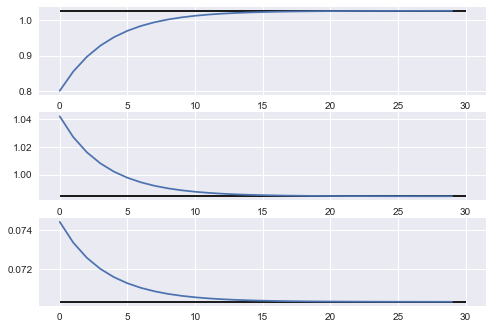

In [14]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(3,1)
ax[0].plot(range(T), kt[:-1])
ax[0].hlines(kss, 0, T)
ax[1].plot(range(T), hyt)
ax[1].hlines(hyss, 0, T)   
ax[2].plot(range(T), hmt)
ax[2].hlines(hmss, 0, T) 

## Question 4 (N)

In the last problem set, we have seen a variant of the neoclassical growth model with two capital stocks, $k$ and $q$. The production function has the following functional form:

\begin{equation}
    f(k, q, h) = A \left[ (\omega k^{\frac{\sigma - 1}{\sigma}} + (1 - \omega) q^{\frac{\sigma - 1}{\sigma}})^{\frac{\sigma}{\sigma-1}}   \right]^\alpha h^{1-\alpha}
\end{equation}

As before, we have a Cobb-Douglas production function. The first argument is a CES composite of the two capital stocks, $k$ and $q$. Recall that a CES function allows you to set an elasticity of substitution $\sigma \in [0, \infty)$ different from 1 (which would be the Cobb-Douglas case). For $\sigma < 1$, the two inputs are considered *complements*, while for $\sigma > 1$, they are *substitutes*.

The resource constraint reads:

\begin{equation}
    k_{t+1} + q_{t+1} + c_t = f(k_t, q_t, h_t) + (1 - \delta) (k_t + q_t)
\end{equation}

where we have assumed that both types of capital depreciate with the same rate $\delta$. 

In contrast to the previous problem set, the planner's problem has an infinite time horizon:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, q_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}

s.t. the resource constraint.

Use the dynamic programming algorithm from the lecture to solve this model for the parameter values given below. Note that since there are two state variables, $k$ and $q$, the value function here is a function with two arguments. Derive approximations to the policy functions and simulate the economy for $T = 30$. Compare these time series to their corresponding steady state values.

In [15]:
## utility
beta = 0.9      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
B = 1

## production
alpha = 0.25
delta = 0.1
A = 1

## CES parameters
omega = 0.5
sigma = 0.8

### Answer

In [16]:
params = {'beta': beta, 'nu': nu, 'eta': eta, 'alpha': alpha, 
          'delta': delta, 'A': A, 'B': B, 'omega': omega, 'sigma': sigma }

#### Auxiliary Functions

In [17]:
def ces(k, q, pm):
    """
    Implements the CES function
    """
    rho = (pm['sigma'] - 1) / pm['sigma']
    return (pm['omega'] * k**rho + (1 - pm['omega']) * q**rho)**(1/rho)

def f(k, q, h, pm):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for k, q and h
    """
    return pm['A'] * ces(k, q, pm)**pm['alpha'] * h**(1 - pm['alpha'])


def f_diff(k, q, h, pm):
    """
    Returns the first derivative of the cobb douglas wrt k, hy and hm
    """
    rho = (pm['sigma'] - 1) / pm['sigma']
    return (pm['alpha'] * pm['A'] * h**(1 - pm['alpha']) * ces(k, q, pm)**(pm['alpha'] - rho) * pm['omega'] * k**(rho - 1) , 
            (1 - pm['alpha']) * f(k, q, h, pm) / h)

def u(c, h, pm):
    """
    Utility function
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])

#### Compute Steady State

In [18]:
def steady(x, pm):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(3)
    X = np.exp(x)
    mp = f_diff(X[0], X[1], X[2], pm)
    
    y[0] = pm['beta'] * (mp[0] + 1 - pm['delta']) - 1
    y[1] = ( f(X[0], X[1], X[2], pm) - pm['delta'] * (X[0] + X[1]))**(- pm['nu']) * mp[1] - pm['B'] * X[2]**pm['eta']
    y[2] = pm['omega'] * X[0]**((pm['sigma']- 1)/pm['sigma'] - 1) - (1 - pm['omega']) * X[1]**((pm['sigma']- 1)/pm['sigma'] - 1)
    
    return y

x0 = np.log([0.5, 0.5, 1.2])
res_ss = scipy.optimize.root(steady, x0, args = (params), method = 'broyden2' , options = {'line_search' : None, 'jac_options': {'alpha': 1}})
print(res_ss)

kss = np.exp(res_ss.x)[0]
qss = np.exp(res_ss.x)[1]
hss = np.exp(res_ss.x)[2]

print( "Steady state: (k_ss, q_ss, h_ss) = {}".format(np.exp(res_ss.x) ) )

     fun: array([  1.40191458e-07,   3.47020848e-08,  -2.36498902e-07])
 message: 'A solution was found at the specified tolerance.'
     nit: 13
  status: 1
 success: True
       x: array([-0.65239895, -0.65239912,  0.04636322])
Steady state: (k_ss, q_ss, h_ss) = [ 0.52079492  0.52079483  1.0474548 ]


#### Choose a grid around the steady state value for capital

In [19]:
m = 10
k_min, k_max = 0.3, 0.8
q_min, q_max = 0.3, 0.8
k_grid = fa.chebgrid(k_min, k_max, m)
q_grid = fa.chebgrid(q_min, q_max, m)

Q_grid, K_grid = np.meshgrid(q_grid, k_grid)

#### Set the degree of approximation and an initial guess for the value function

In [20]:
## set the degree of approximation
n = m - 1

## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(K_grid )
## compute implied basis coefficients
a0 = fa.chebapprox_2d(V0, [n, n])

#### Define the objective function for the optimization step (= RHS of Bellman equation)

In [21]:
def vf_rhs(x, k, q, a, k_min, k_max, q_min, q_max, pm):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[0])
    qp = np.exp(x[1])
    h = np.exp(x[2])
    
    return (- u(f(k, q, h, pm) + (1 - pm['delta']) * (k + q) - kp - qp, h, pm) 
            - beta * np.polynomial.chebyshev.chebval2d(fa.chebconvert(kp, k_min, k_max),
                                                       fa.chebconvert(qp, q_min, q_max), a) )

#### Solve model with value function iteration

In [22]:
def opt_step(k_grid, q_grid, obj_fun, x0, a_ch, k_min, k_max, q_min, q_max, pm):     
    """
    Function that loops over all states (= elements in k_grid and q_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros((m, m))
    K = np.zeros((m, m))
    Q = np.zeros((m, m))
    H = np.zeros((m, m))
    
    ## loop
    for (ind1, k) in enumerate(k_grid):
        for (ind2, q) in enumerate(q_grid):
        ## optimization step
            res = scipy.optimize.minimize(obj_fun, x0, args = (k, q, a_ch, k_min, k_max, q_min, q_max, pm), method ='BFGS') 
            V[ind1, ind2] = - res.fun
            K[ind1, ind2], Q[ind1, ind2], H[ind1, ind2]  = np.exp( res.x )
            if res.success is not True:
                print(k, q, res.message)
        
    return V, K, Q, H

In [23]:
## initialize initial guess for basis coefficients and optimization
a_ch = a0.copy()
# x0 = np.log([1.2, 1.2, 0.2])
# x0 = np.log([1, 1, 1])
x0 = res_ss.x

eps = 1
it = 0
maxit = 300

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, Q, H = opt_step(k_grid, q_grid, vf_rhs, x0, a_ch, k_min, k_max, q_min, q_max, params)
    ## fitting step
    a_new = fa.chebapprox_2d(V, [n, n])
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()
    
    if it % 10 == 0:
        print(it, eps)

print(it, eps)

0.373223304703 0.796922085149 Desired error not necessarily achieved due to precision loss.
0.51089138374 0.51089138374 Desired error not necessarily achieved due to precision loss.
0.663497624935 0.726776695297 Desired error not necessarily achieved due to precision loss.
0.726776695297 0.663497624935 Desired error not necessarily achieved due to precision loss.
0.726776695297 0.796922085149 Desired error not necessarily achieved due to precision loss.
0.796922085149 0.373223304703 Desired error not necessarily achieved due to precision loss.
0.796922085149 0.726776695297 Desired error not necessarily achieved due to precision loss.
10 0.746940488195
20 0.260682495853
30 0.0908979868776
40 0.0316942451632
50 0.0110511016066
60 0.00385328090468
70 0.0013435559761
80 0.00046846900203
90 0.000163345040544
100 5.69548941129e-05
110 1.98589435101e-05
120 6.92438544903e-06
130 2.41438386794e-06
140 8.41843721847e-07
150 2.93532934851e-07
160 1.02348511913e-07
170 3.56869627506e-08
180 1.244

#### Simulation

In [24]:
a_k = fa.chebapprox_2d(K, [n, n])
a_q = fa.chebapprox_2d(Q, [n, n])
a_h = fa.chebapprox_2d(H, [n, n])

In [25]:
## number of periods
T = 30
k0 = 0.33

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
qt = np.zeros(T+1)
ht = np.zeros(T)


## initial capital stock is given
kt[0] = k0
qt[0] = k0

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(qt[t], k_min, k_max), a_k )
    qt[t+1] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(qt[t], k_min, k_max), a_q )
    ht[t] = np.polynomial.chebyshev.chebval2d( fa.chebconvert(kt[t], k_min, k_max), fa.chebconvert(qt[t], k_min, k_max), a_h )

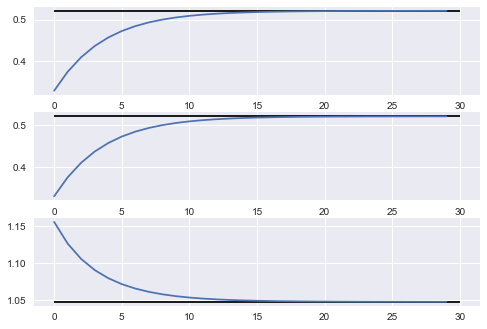

In [26]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(3,1)
ax[0].plot(range(T), kt[:-1])
ax[0].hlines(kss, 0, T)
ax[1].plot(range(T), qt[:-1])
ax[1].hlines(qss, 0, T)   
ax[2].plot(range(T), ht)
ax[2].hlines(hss, 0, T) 